In [ ]:
# Mount Your Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Run The Setup

%cd /content
print("Cloning repositories...")
!git clone https://github.com/xinntao/Real-ESRGAN.git
!git clone https://github.com/xinntao/basicsr.git

print("Installing basicsr dependencies...")
%cd /content/basicsr
!pip install -r requirements.txt
!python setup.py develop

print("Installing Real-ESRGAN dependencies...")
%cd /content/Real-ESRGAN
!pip install -r requirements.txt
!python setup.py develop

print("✅ Setup complete! Ready for GPU training.")

/content
Cloning repositories...
Cloning into 'Real-ESRGAN'...
remote: Enumerating objects: 759, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 759 (delta 106), reused 99 (delta 99), pack-reused 638 (from 1)
Receiving objects: 100% (759/759), 5.38 MiB | 11.36 MiB/s, done.
Resolving deltas: 100% (415/415), done.
Cloning into 'basicsr'...
remote: Enumerating objects: 5924, done.
remote: Total 5924 (delta 0), reused 0 (delta 0), pack-reused 5924 (from 1)
Receiving objects: 100% (5924/5924), 4.14 MiB | 8.77 MiB/s, done.
Resolving deltas: 100% (3758/3758), done.
Installing basicsr dependencies...
/content/basicsr
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.4/299.4 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 15.3 MB/s eta 0:0

In [ ]:
# Preparing Training Data ===

import zipfile, os, cv2
from tqdm import tqdm
from pathlib import Path


zip_path = "/content/drive/MyDrive/IMAGE_SR/faces_dataset_small_zip.zip"
dataset_root = Path("/content/dataset_faces")
src_dir = dataset_root / "faces_dataset_small"
hr_dir = dataset_root / "HR"
lr_dir = dataset_root / "LR"

# Extracting dataset
os.makedirs(dataset_root, exist_ok=True)
print("📦 Extracting dataset zip...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_root)
print(f"Extracted to {dataset_root}")

# Preparing HR/LR directories
hr_dir.mkdir(exist_ok=True, parents=True)
lr_dir.mkdir(exist_ok=True, parents=True)
for img_path in src_dir.glob("*.*"):
    if img_path.suffix.lower() in [".jpg", ".jpeg", ".png"]:
        img_path.rename(hr_dir / img_path.name)

# Generating LR images
scale = 4
print("⏳ Generating LR images...")
for img_path in tqdm(list(hr_dir.glob("*"))):
    img = cv2.imread(str(img_path))
    if img is None: continue
    h, w = img.shape[:2]
    h, w = (h // scale) * scale, (w // scale) * scale
    if h == 0 or w == 0: continue
    img = img[0:h, 0:w]
    lr_img = cv2.resize(img, (w // scale, h // scale), interpolation=cv2.INTER_CUBIC)
    cv2.imwrite(str(lr_dir / img_path.name), lr_img)

print(f"✅ HR/LR data created.")

📦 Extracting dataset zip...
Extracted to /content/dataset_faces
⏳ Generating LR images...


100%|██████████| 3143/3143 [02:32<00:00, 20.60it/s]

✅ HR/LR data created.


In [ ]:
# Create Validation Set

import os, glob
from pathlib import Path
print("Creating validation set...")

SRC_HR_DIR = Path("/content/dataset_faces/HR")
SRC_LR_DIR = Path("/content/dataset_faces/LR")
VAL_HR_DIR = Path("/content/dataset_faces/HR_val")
VAL_LR_DIR = Path("/content/dataset_faces/LR_val")

VAL_HR_DIR.mkdir(exist_ok=True)
VAL_LR_DIR.mkdir(exist_ok=True)

hr_files = sorted(list(SRC_HR_DIR.glob("*")))
val_files_to_move = hr_files[:100]

if not val_files_to_move:
    print("⚠️ WARNING: No files found to move.")
else:
    print(f"Moving {len(val_files_to_move)} files to validation set...")
    for hr_path in val_files_to_move:
        lr_path = SRC_LR_DIR / hr_path.name
        if lr_path.exists():
            hr_path.rename(VAL_HR_DIR / hr_path.name)
            lr_path.rename(VAL_LR_DIR / lr_path.name)

print("✅ Validation set created.")

Creating validation set...
Moving 100 files to validation set...
✅ Validation set created.


In [ ]:
# Create 20k YAML (Seeded by 9k model)

import os
YOUR_9K_MODEL_PATH = "/content/drive/MyDrive/RealESRGAN_Experiments/FaceESRGAN_finetune_10k_v2/models/net_g_9000.pth"
YOUR_NEW_EXPERIMENT_PATH = "/content/drive/MyDrive/RealESRGAN_Experiments"

config_yaml = f"""
# ===========================================================
# Real-ESRGAN 20k-Iteration Run (Seeded by 9k model)
# ===========================================================

name: FaceESRGAN_finetune_20k_v1 # A new name for this new run
model_type: SRGANModel
scale: 4
num_gpu: 1
manual_seed: 42

# =====================================
# Datasets
# =====================================
datasets:
  train:
    name: FaceTrain
    type: PairedImageDataset
    dataroot_gt: /content/dataset_faces/HR
    dataroot_lq: /content/dataset_faces/LR
    io_backend: {{type: disk}}
    gt_size: 256
    use_hflip: true
    use_rot: true
    num_worker_per_gpu: 2
    batch_size_per_gpu: 2
    phase: train
  val:
    name: FaceVal
    type: PairedImageDataset
    dataroot_gt: /content/dataset_faces/HR_val
    dataroot_lq: /content/dataset_faces/LR_val
    io_backend: {{type: disk}}
    gt_size: 256
    phase: val

# =====================================
# Networks
# =====================================
network_g: {{type: RRDBNet, num_in_ch: 3, num_out_ch: 3, num_feat: 64, num_block: 23, num_grow_ch: 32, scale: 4}}
network_d: {{type: UNetDiscriminatorSN, num_in_ch: 3, num_feat: 48}}

# =====================================
# Paths (The "Seeding" Method)
# =====================================
path:
  # 1. THIS IS THE KEY: Loading the 9k model as the starting point
  pretrain_network_g: {YOUR_9K_MODEL_PATH}

  strict_load_g: false
  param_key_g: params_ema

  # 2. All new save files will go to the new experiment folder
  experiments_root: {YOUR_NEW_EXPERIMENT_PATH}
  models: models
  training_states: training_states
  log: log
  results_root: results

# =====================================
# Training Settings (A new 10k run)
# =====================================
train:
  total_iter: 10000
  warmup_iter: -1
  use_amp: true
  freeze_layers_g: 20

  optim_g: {{type: Adam, lr: 0.00005, weight_decay: 0.0, betas: [0.9, 0.99]}}
  optim_d: {{type: Adam, lr: 0.00005, weight_decay: 0.0, betas: [0.9, 0.99]}}

  scheduler:
    type: MultiStepLR
    milestones: [6000, 9000] # 60% and 90% of 10k
    gamma: 0.5

  pixel_opt: {{type: L1Loss, loss_weight: 1.0, reduction: mean}}
  perceptual_opt:
    type: PerceptualLoss
    layer_weights: {{'conv5_4': 1.0}}
    perceptual_weight: 1.0
    style_weight: 0
    use_input_norm: true
    range_norm: false
    criterion: l1
  gan_opt: {{type: GANLoss, gan_type: lsgan, loss_weight: 0.05}}

# =====================================
# Validation
# =====================================
val:
  val_freq: 2000
  save_img: true
  metrics:
    psnr: {{type: calculate_psnr, crop_border: 4, test_y_channel: true}}
    ssim: {{type: calculate_ssim, crop_border: 4, test_y_channel: true}}

# =====================================
# Logger
# =====================================
logger:
  print_freq: 50
  save_checkpoint_freq: 2000 # Save every 2000 iters
  use_tb_logger: false
  wandb: {{project: ~, resume_id: ~}}

# =====================================
# Distributed Training
# =====================================
dist_params: {{backend: gloo, port: 29500}}
"""

# Create YAML file
os.makedirs("/content/Real-ESRGAN/options/finetune", exist_ok=True)
new_yml_path = "/content/Real-ESRGAN/options/finetune/FaceESRGAN_finetune_20k_v1.yml"

# Clean the string just in case
cleaned_yaml = config_yaml.encode("ascii", "ignore").decode("utf-8")
with open(new_yml_path, "w") as f:
    f.write(cleaned_yaml)

print(f"20k Iteration YAML created at: {new_yml_path}")
print(f"Loading the 9k model from: {YOUR_9K_MODEL_PATH}")

✅ 20k Iteration YAML created at: /content/Real-ESRGAN/options/finetune/FaceESRGAN_finetune_20k_v1.yml
➡️  Loading the 9k model from: /content/drive/MyDrive/RealESRGAN_Experiments/FaceESRGAN_finetune_10k_v2/models/net_g_9000.pth


In [ ]:
# Running the 20k Training

%cd /content/Real-ESRGAN
!python ../basicsr/basicsr/train.py -opt options/finetune/FaceESRGAN_finetune_20k_v1.yml

/content/Real-ESRGAN
Disable distributed.
2025-11-05 13:18:11,803 INFO: 
                ____                _       _____  ____
               / __ ) ____ _ _____ (_)_____/ ___/ / __ \
              / __  |/ __ `// ___// // ___/\__ \ / /_/ /
             / /_/ // /_/ /(__  )/ // /__ ___/ // _, _/
            /_____/ \__,_//____//_/ \___//____//_/ |_|
     ______                   __   __                 __      __
    / ____/____   ____   ____/ /  / /   __  __ _____ / /__   / /
   / / __ / __ \ / __ \ / __  /  / /   / / / // ___// //_/  / /
  / /_/ // /_/ // /_/ // /_/ /  / /___/ /_/ // /__ / /<    /_/
  \____/ \____/ \____/ \____/  /_____/\____/ \___//_/|_|  (_)
    
Version Information: 
	BasicSR: 1.4.2
	PyTorch: 2.8.0+cu126
	TorchVision: 0.23.0+cu126
2025-11-05 13:18:11,805 INFO: 
  name: FaceESRGAN_finetune_20k_v1
  model_type: SRGANModel
  scale: 4
  num_gpu: 1
  manual_seed: 42
  datasets:[
    train:[
      name: FaceTrain
      type: PairedImageDataset
      dataroot_gt: /cont

Running inference with the CHAMPION model on: 00299.png...
Testing 0 00299
✅ Inference complete in 6.03 seconds!
Loading images for comparison...
Displaying comparison...


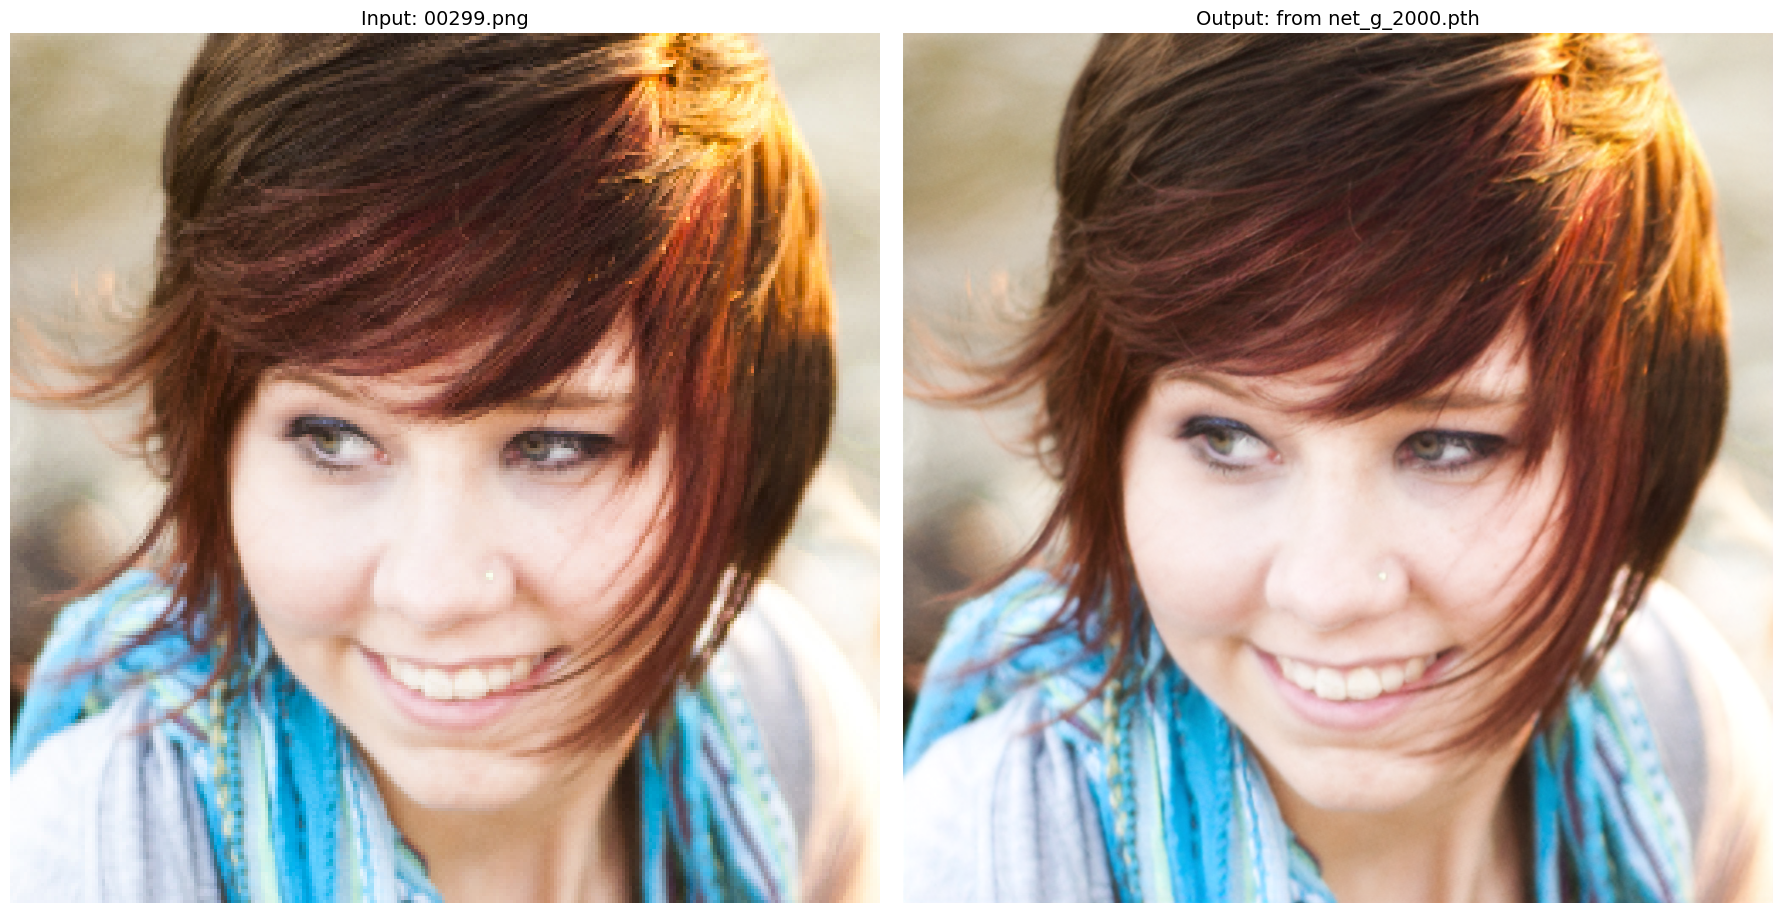

In [ ]:
filename = "00299.png"

import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display, Image, clear_output
import time

MODEL_TO_TEST = "net_g_2000.pth"
INPUT_FOLDER = "/content/drive/MyDrive/demo_images_lr_bicubic"
OUTPUT_FOLDER = "/content/temp_demo_results"
INPUT_FILE = os.path.join(INPUT_FOLDER, filename)

EXPERIMENT_NAME = "FaceESRGAN_finetune_20k_v1"
MODEL_PATH = f"/content/drive/MyDrive/RealESRGAN_Experiments/{EXPERIMENT_NAME}/models/{MODEL_TO_TEST}"
INFERENCE_SCRIPT_PATH = "/content/Real-ESRGAN/inference_realesrgan.py"


if not os.path.exists(INFERENCE_SCRIPT_PATH):
    print("❌ ERROR: 'inference_realesrgan.py' not found.")

elif not os.path.exists(INPUT_FILE):
    print(f"❌ ERROR: File not found: {INPUT_FILE}")

elif not os.path.exists(MODEL_PATH):
    print(f"❌ ERROR: Champion model not found at: {MODEL_PATH}")

else:
    print(f"Running inference with the CHAMPION model on: {filename}...")
    start_time = time.time()

    !mkdir -p {OUTPUT_FOLDER}

    !python {INFERENCE_SCRIPT_PATH} \
        -i {INPUT_FILE} \
        -o {OUTPUT_FOLDER} \
        --outscale 4 \
        --model_path {MODEL_PATH}

    end_time = time.time()
    print(f"✅ Inference complete in {end_time - start_time:.2f} seconds!")

    print("Loading images for comparison...")

    input_basename = os.path.basename(INPUT_FILE)
    input_name_without_ext, input_ext = os.path.splitext(input_basename)
    output_glob_pattern = f"{OUTPUT_FOLDER}/{input_name_without_ext}_out{input_ext}"
    output_path_list = glob.glob(output_glob_pattern)

    if not output_path_list:
        print(f"Error: Output file not found. Inference may have failed.")
    else:
        output_path = output_path_list[0]

        try:
            img_in = mpimg.imread(INPUT_FILE)
            img_out = mpimg.imread(output_path)

            print("Displaying comparison...")

            fig, ax = plt.subplots(1, 2, figsize=(18, 9))

            ax[0].imshow(img_in)
            ax[0].set_title(f'Input: {input_basename}', fontsize=14)
            ax[0].axis('off')

            ax[1].imshow(img_out)
            ax[1].set_title(f'Output: from {MODEL_TO_TEST}', fontsize=14)
            ax[1].axis('off')

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"An error occurred while trying to display the images: {e}")